# phonon calculation style

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

Description updated: 2019-07-26

## Introduction

The phonon calculation style applies small atomic displacements to a unit cell system and evaluates the forces on the atoms to evaluate phonon-based properties.

### Version notes

### Additional dependencies

- [spglib](https://atztogo.github.io/spglib/python-spglib.html)
- [phonopy](https://atztogo.github.io/phonopy/)
- [seekpath](https://pypi.org/project/seekpath/)

### Disclaimers

- [NIST disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)


## Method and Theory

Starting with an initial system, [spglib](https://atztogo.github.io/spglib/python-spglib.html) is used to identify the associated primitive unit cell.  The primitive cell is passed to [phonopy](https://atztogo.github.io/phonopy/), which constructs super cell systems with small atomic displacements.  A LAMMPS calculation is performed on the displaced systems to evaluate the atomic forces on each atom without relaxing.  The measured atomic forces are then passed back to phonopy, which computes force constants for the system.  Plots are then created for the band structure, density of states, and other thermal properties.

See [phonopy](https://atztogo.github.io/phonopy/) documentation for more details about the package and the associated theory.


## Demonstration

### 1. Setup

#### 1.1. Library imports

Import libraries needed by the calculation. The external libraries used are:

- [numpy](http://www.numpy.org/)

- [DataModelDict](https://github.com/usnistgov/DataModelDict)

- [atomman](https://github.com/usnistgov/atomman)

- [iprPy](https://github.com/usnistgov/iprPy)

In [1]:
# Standard library imports
from pathlib import Path
import os
import sys
import uuid
import shutil
import datetime
from collections import OrderedDict
from math import floor
from copy import deepcopy

# http://www.numpy.org/
import numpy as np

# https://matplotlib.org/
import matplotlib.pyplot as plt

# https://atztogo.github.io/spglib/python-spglib.html
import spglib

# https://atztogo.github.io/phonopy/phonopy-module.html
import phonopy

# https://github.com/usnistgov/DataModelDict 
from DataModelDict import DataModelDict as DM

# https://github.com/usnistgov/atomman 
import atomman as am
import atomman.lammps as lmp
import atomman.unitconvert as uc

# https://github.com/usnistgov/iprPy
import iprPy

from IPython.display import Image

print('Notebook last executed on', datetime.date.today(), 'using iprPy version', iprPy.__version__)

Notebook last executed on 2019-07-29 using iprPy version 0.9.0


#### 1.2. Default calculation setup

In [2]:
# Specify calculation style
calc_style = 'phonon'

# If workingdir is already set, then do nothing (already in correct folder)
try:
    workingdir = workingdir

# Change to workingdir if not already there
except:
    workingdir = Path('calculationfiles', calc_style)
    if not workingdir.is_dir():
        workingdir.mkdir(parents=True)
    os.chdir(workingdir)

### 2. Assign values for the calculation's run parameters

#### 2.1. Specify system-specific paths

- __lammps_command__ is the LAMMPS command to use (required).

- __mpi_command__ MPI command for running LAMMPS in parallel. A value of None will run simulations serially.

In [3]:
lammps_command = 'lmp_serial'
mpi_command = None

#### 2.2. Load interatomic potential

- __potential_name__ gives the name of the potential_LAMMPS reference record in the iprPy library to use for the calculation.  

- __potential_file__ gives the path to the potential_LAMMPS reference record to use.  Here, this parameter is automatically generated using potential_name and librarydir.

- __potential_dir__ gives the path for the folder containing the artifacts associated with the potential (i.e. eam.alloy file).  Here, this parameter is automatically generated using potential_name and librarydir.

- __potential__ is an atomman.lammps.Potential object (required).  Here, this parameter is automatically generated from potential_file and potential_dir.

In [4]:
potential_name = '1999--Mishin-Y--Ni--LAMMPS--ipr1'

# Define potential_file and potential_dir using librarydir and potential_name
potential_file = Path(iprPy.libdir, 'potential_LAMMPS', f'{potential_name}.json')
potential_dir = Path(iprPy.libdir, 'potential_LAMMPS', potential_name)

# Initialize Potential object using potential_file and potential_dir.
potential = lmp.Potential(potential_file, potential_dir)
print('Successfully loaded potential', potential)

Successfully loaded potential 1999--Mishin-Y--Ni--LAMMPS--ipr1


#### 2.3. Load initial unit cell system

- __prototype_name__ gives the name of the crystal_prototype reference record in the iprPy library to load. 

- __symbols__ is a list of the potential's elemental model symbols to associate with the unique atom types of the loaded system. 

- __box_parameters__ is a list of the a, b, c lattice constants to assign to the loaded file.

- __load_file__ gives the path to the atomic configuration file to load for the ucell system.  Here, this is generated automatically using prototype_name and librarydir.

- __load_style__ specifies the format of load_file.  Here, this is automatically set for crystal_prototype records.

- __load_options__ specifies any other keyword options for properly loading the load_file.  Here, this is automatically set for crystal_prototype records.

- __ucell__ is an atomman.System representing a fundamental unit cell of the system (required).  Here, this is generated using the load_* parameters and symbols.

In [5]:
prototype_name = 'A1--Cu--fcc'
symbols = ['Ni']
box_parameters = uc.set_in_units([3.52, 3.52, 3.52], 'angstrom')

# Define load_file using librarydir and prototype_name
load_file = Path(iprPy.libdir, 'crystal_prototype', f'{prototype_name}.json')

# Define load_style and load_options for crystal_prototype records
load_style = 'system_model'
load_options = {}

# Create ucell by loading prototype record
ucell = am.load(load_style, load_file, symbols=symbols, **load_options)

# Rescale ucell using box_parameters
ucell.box_set(a=box_parameters[0], b=box_parameters[1], c=box_parameters[2], scale=True)

print(ucell)

avect =  [ 3.520,  0.000,  0.000]
bvect =  [ 0.000,  3.520,  0.000]
cvect =  [ 0.000,  0.000,  3.520]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = ('Ni',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   1.760 |   1.760
      2 |       1 |   1.760 |   0.000 |   1.760
      3 |       1 |   1.760 |   1.760 |   0.000


#### 2.4. Modify system

- __sizemults__ list of three integers specifying how many times the ucell vectors of $a$, $b$ and $c$ are replicated in creating system.

In [6]:
sizemults = [3, 3, 3]

#### 2.5. Specify calculation-specific run parameters

- __displacementdistance__ is the displacement distance scalar to use when applying random displacements to the atoms to compute the force constants.   
- __symmetryprecision__ is the absolute precision tolerance to use in determining crystal symmetry elements for identifying the primitive unit cell.         

In [7]:
displacementdistance = uc.set_in_units(0.01, 'angstrom')
symmetryprecision = 1e-5

### 3. Define calculation function(s) and generate template LAMMPS script(s)

#### 3.1. phonon.template

In [8]:
with open('phonon.template', 'w') as f:
    f.write("""# LAMMPS input script that evaluates atomic forces without relaxing

box tilt large

<atomman_system_info>

<atomman_pair_info>

thermo_style custom step pe
thermo_modify format float %.13e

dump dumpy all custom 1 forces.dump id type x y z fx fy fz
dump_modify dumpy format <dump_modify_format>

run 0""")

#### 3.2. phonon()

In [9]:
def phonon(lammps_command, ucell, potential, mpi_command=None, a_mult=5, b_mult=5, c_mult=5,
           distance=0.01, symprec=1e-5):
    
    try:
        # Get script's location if __file__ exists
        script_dir = Path(__file__).parent
    except:
        # Use cwd otherwise
        script_dir = Path.cwd()

    # Get lammps units
    lammps_units = lmp.style.unit(potential.units)
    
    # Get lammps version date
    lammps_date = lmp.checkversion(lammps_command)['date']

    # Generate pair_info
    pair_info = potential.pair_info(ucell.symbols)
    
    # Use spglib to find primitive unit cell of ucell
    convcell = ucell.dump('spglib_cell')
    primcell = spglib.find_primitive(convcell, symprec=symprec)
    primucell = am.load('spglib_cell', primcell, symbols=ucell.symbols).normalize()
    
    # Initialize Phonopy object
    phonon = phonopy.Phonopy(primucell.dump('phonopy_Atoms'), [[a_mult, 0, 0], [0, b_mult, 0], [0, 0, c_mult]])
    phonon.generate_displacements(distance=distance)
    
    # Loop over displaced supercells to compute forces
    forcearrays = []
    for supercell in phonon.supercells_with_displacements:
        
        # Save to LAMMPS data file
        system = am.load('phonopy_Atoms', supercell)
        system_info = system.dump('atom_data', f='disp.dat')
        
        # Define lammps variables
        lammps_variables = {}
        lammps_variables['atomman_system_info'] = system_info
        lammps_variables['atomman_pair_info'] = pair_info

        # Set dump_modify_format based on lammps_date
        if lammps_date < datetime.date(2016, 8, 3):
            lammps_variables['dump_modify_format'] = '"%d %d %.13e %.13e %.13e %.13e %.13e %.13e"'
        else:
            lammps_variables['dump_modify_format'] = 'float %.13e'

        # Write lammps input script
        template_file = Path(script_dir, 'phonon.template')
        lammps_script = 'phonon.in'
        with open(template_file) as f:
            template = f.read()
        with open(lammps_script, 'w') as f:
            f.write(iprPy.tools.filltemplate(template, lammps_variables, '<', '>'))
        
        # Run LAMMPS
        lmp.run(lammps_command, 'phonon.in', mpi_command=mpi_command)
        
        # Extract forces from dump file
        results = am.load('atom_dump', 'forces.dump')
        forces = uc.set_in_units(results.atoms.force, lammps_units['force'])
        forcearrays.append(forces)
    
    # Set computed forces
    phonon.set_forces(forcearrays)
    
    # Save to yaml file    
    phonon.save('phonopy_params.yaml')
    
    # Compute band structure    
    phonon.produce_force_constants()
    phonon.auto_band_structure(plot=True)
    plt.savefig('band.png', dpi=400)
    plt.close()
    
    # Compute total density of states
    phonon.auto_total_dos(plot=True)
    plt.savefig('total_dos.png', dpi=400)
    plt.close()
    
    # Compute partial density of states
    phonon.auto_projected_dos(plot=True)
    plt.savefig('projected_dos.png', dpi=400)
    plt.close()
    
    # Compute thermal properties
    phonon.run_thermal_properties()
    phonon.plot_thermal_properties()
    plt.savefig('thermal.png', dpi=400)
    plt.close()
    
    return {}



### 4. Run calculation function(s)

In [10]:
results_dict = phonon(lammps_command, ucell, potential,
                      mpi_command = mpi_command,
                      a_mult = sizemults[0],
                      b_mult = sizemults[1],
                      c_mult = sizemults[2],
                      distance = displacementdistance,
                      symprec = symmetryprecision)

In [11]:
results_dict.keys()

dict_keys([])

### 5. Report results

#### 5.1. Show band structure plot

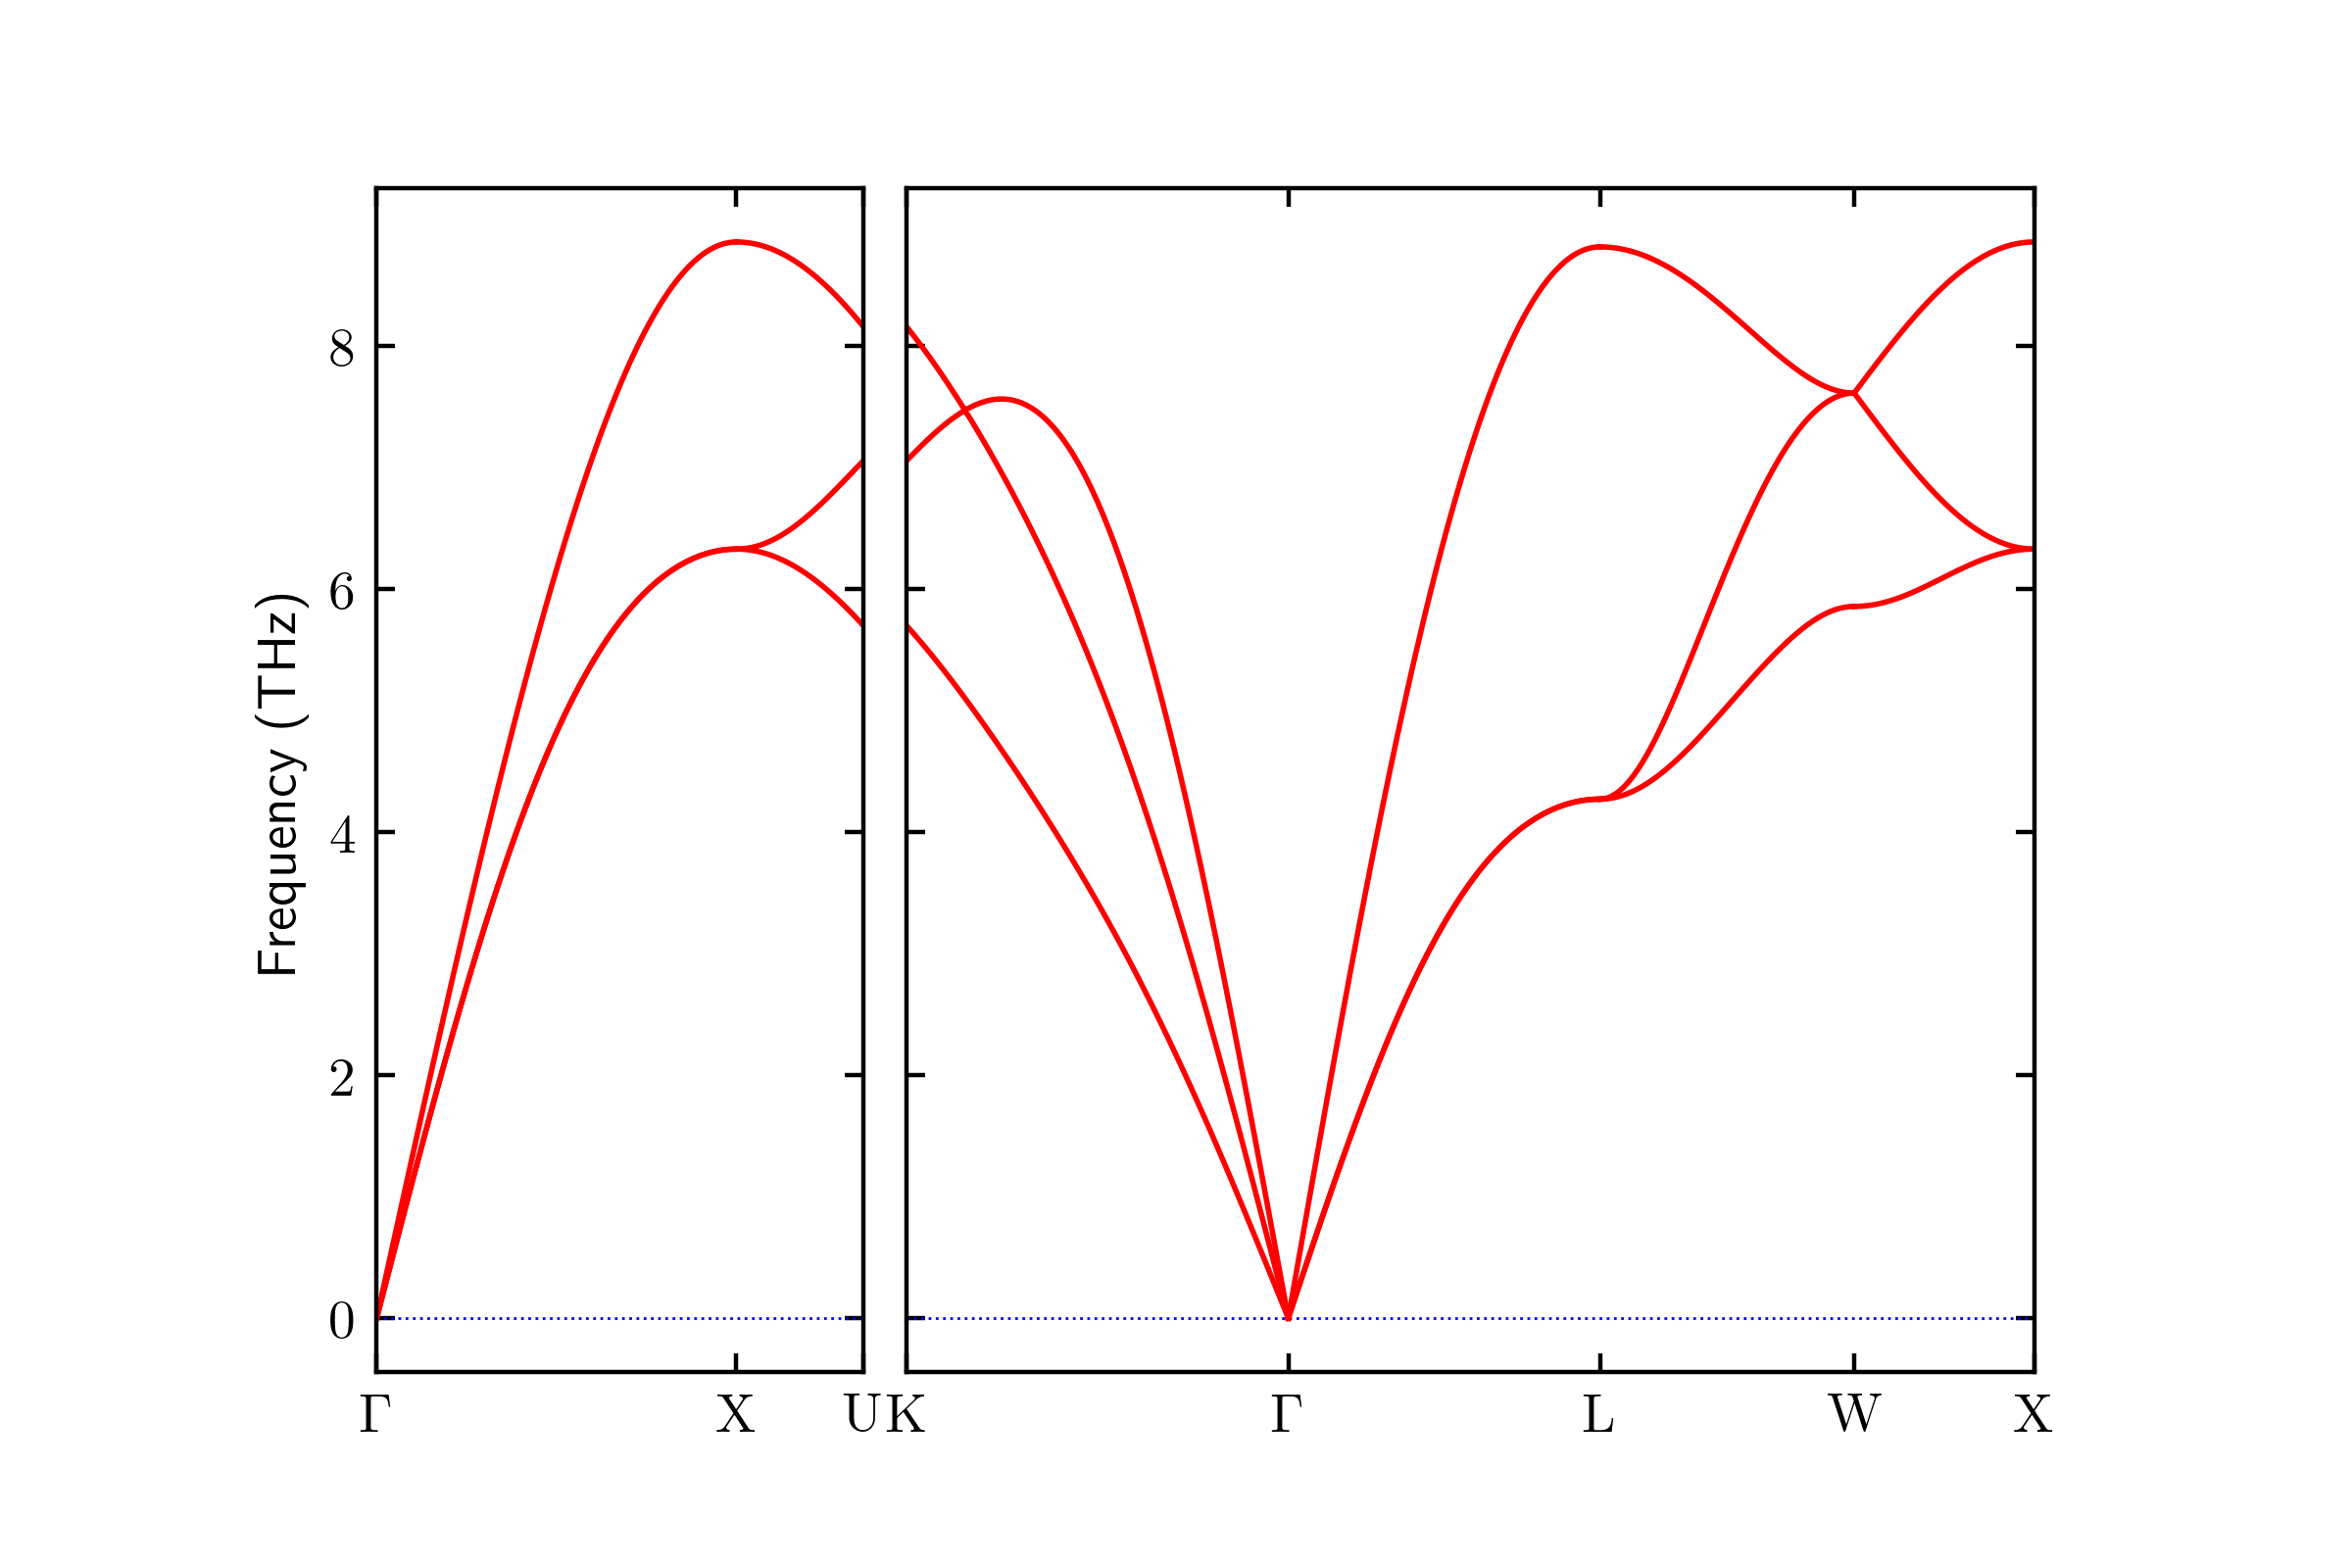

In [12]:
Image("band.png", width=600)

#### 5.2. Show total density of states 

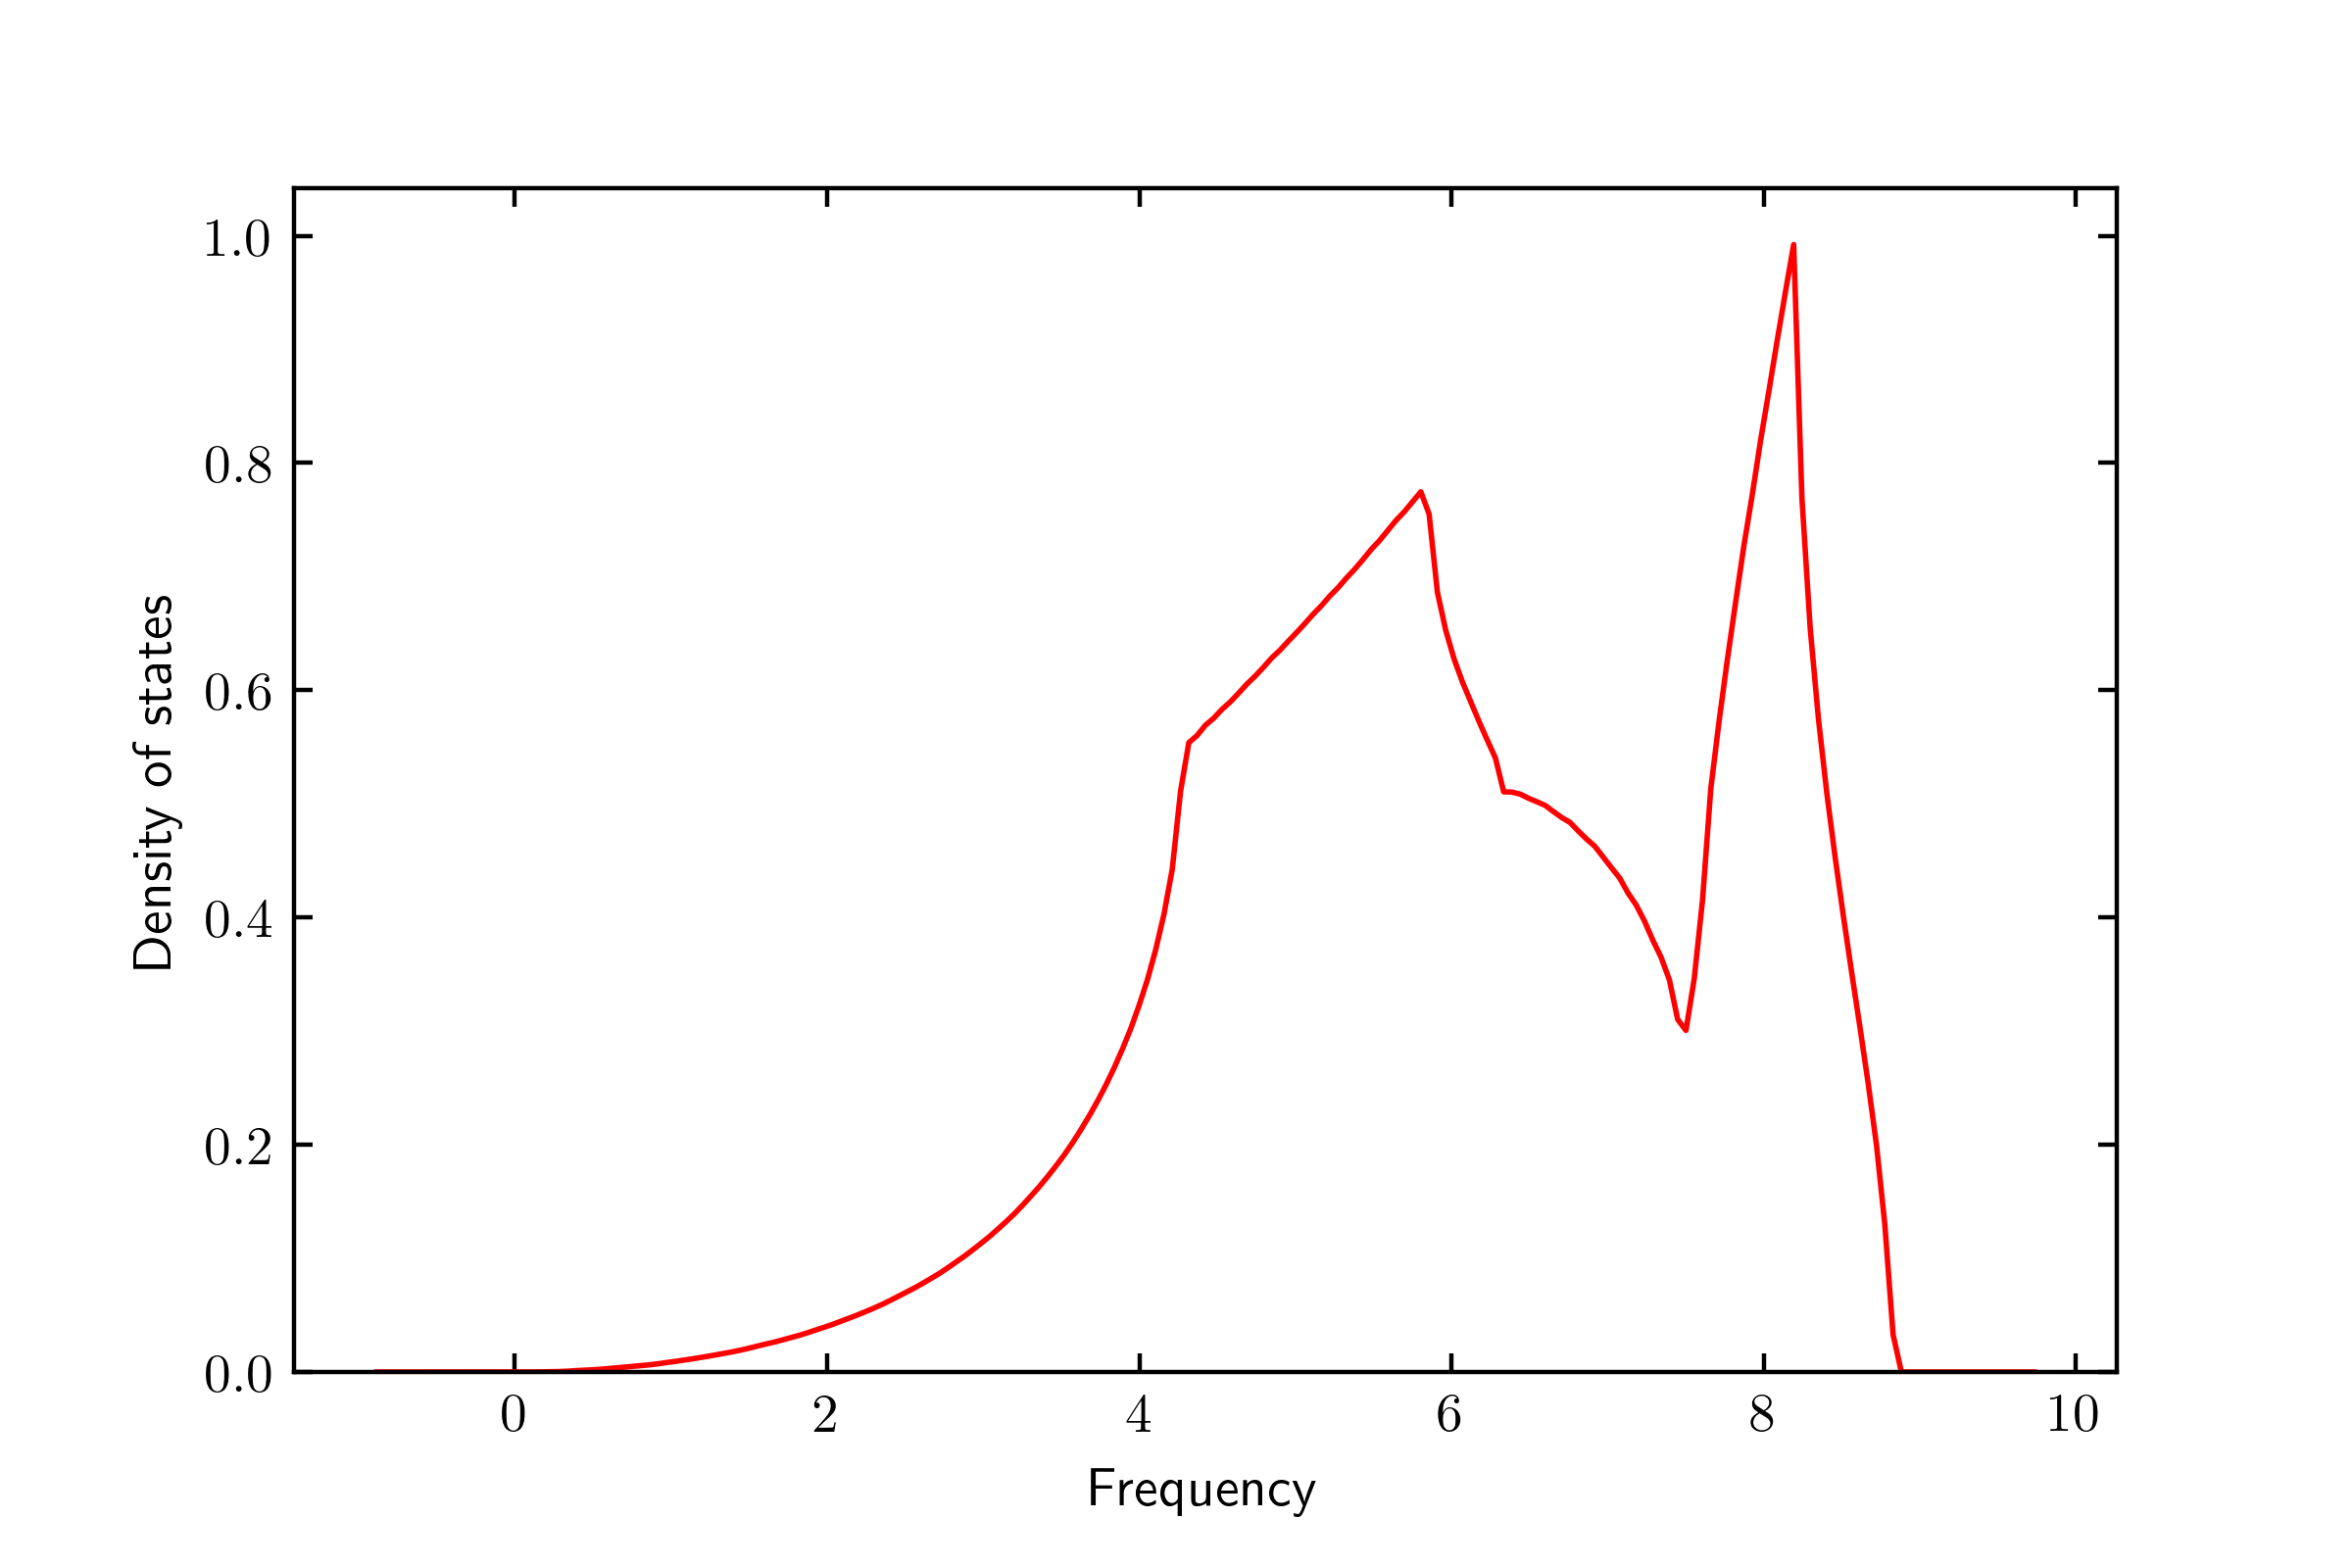

In [13]:
Image("total_dos.png", width=600)

#### 5.3. Show projected density of states 

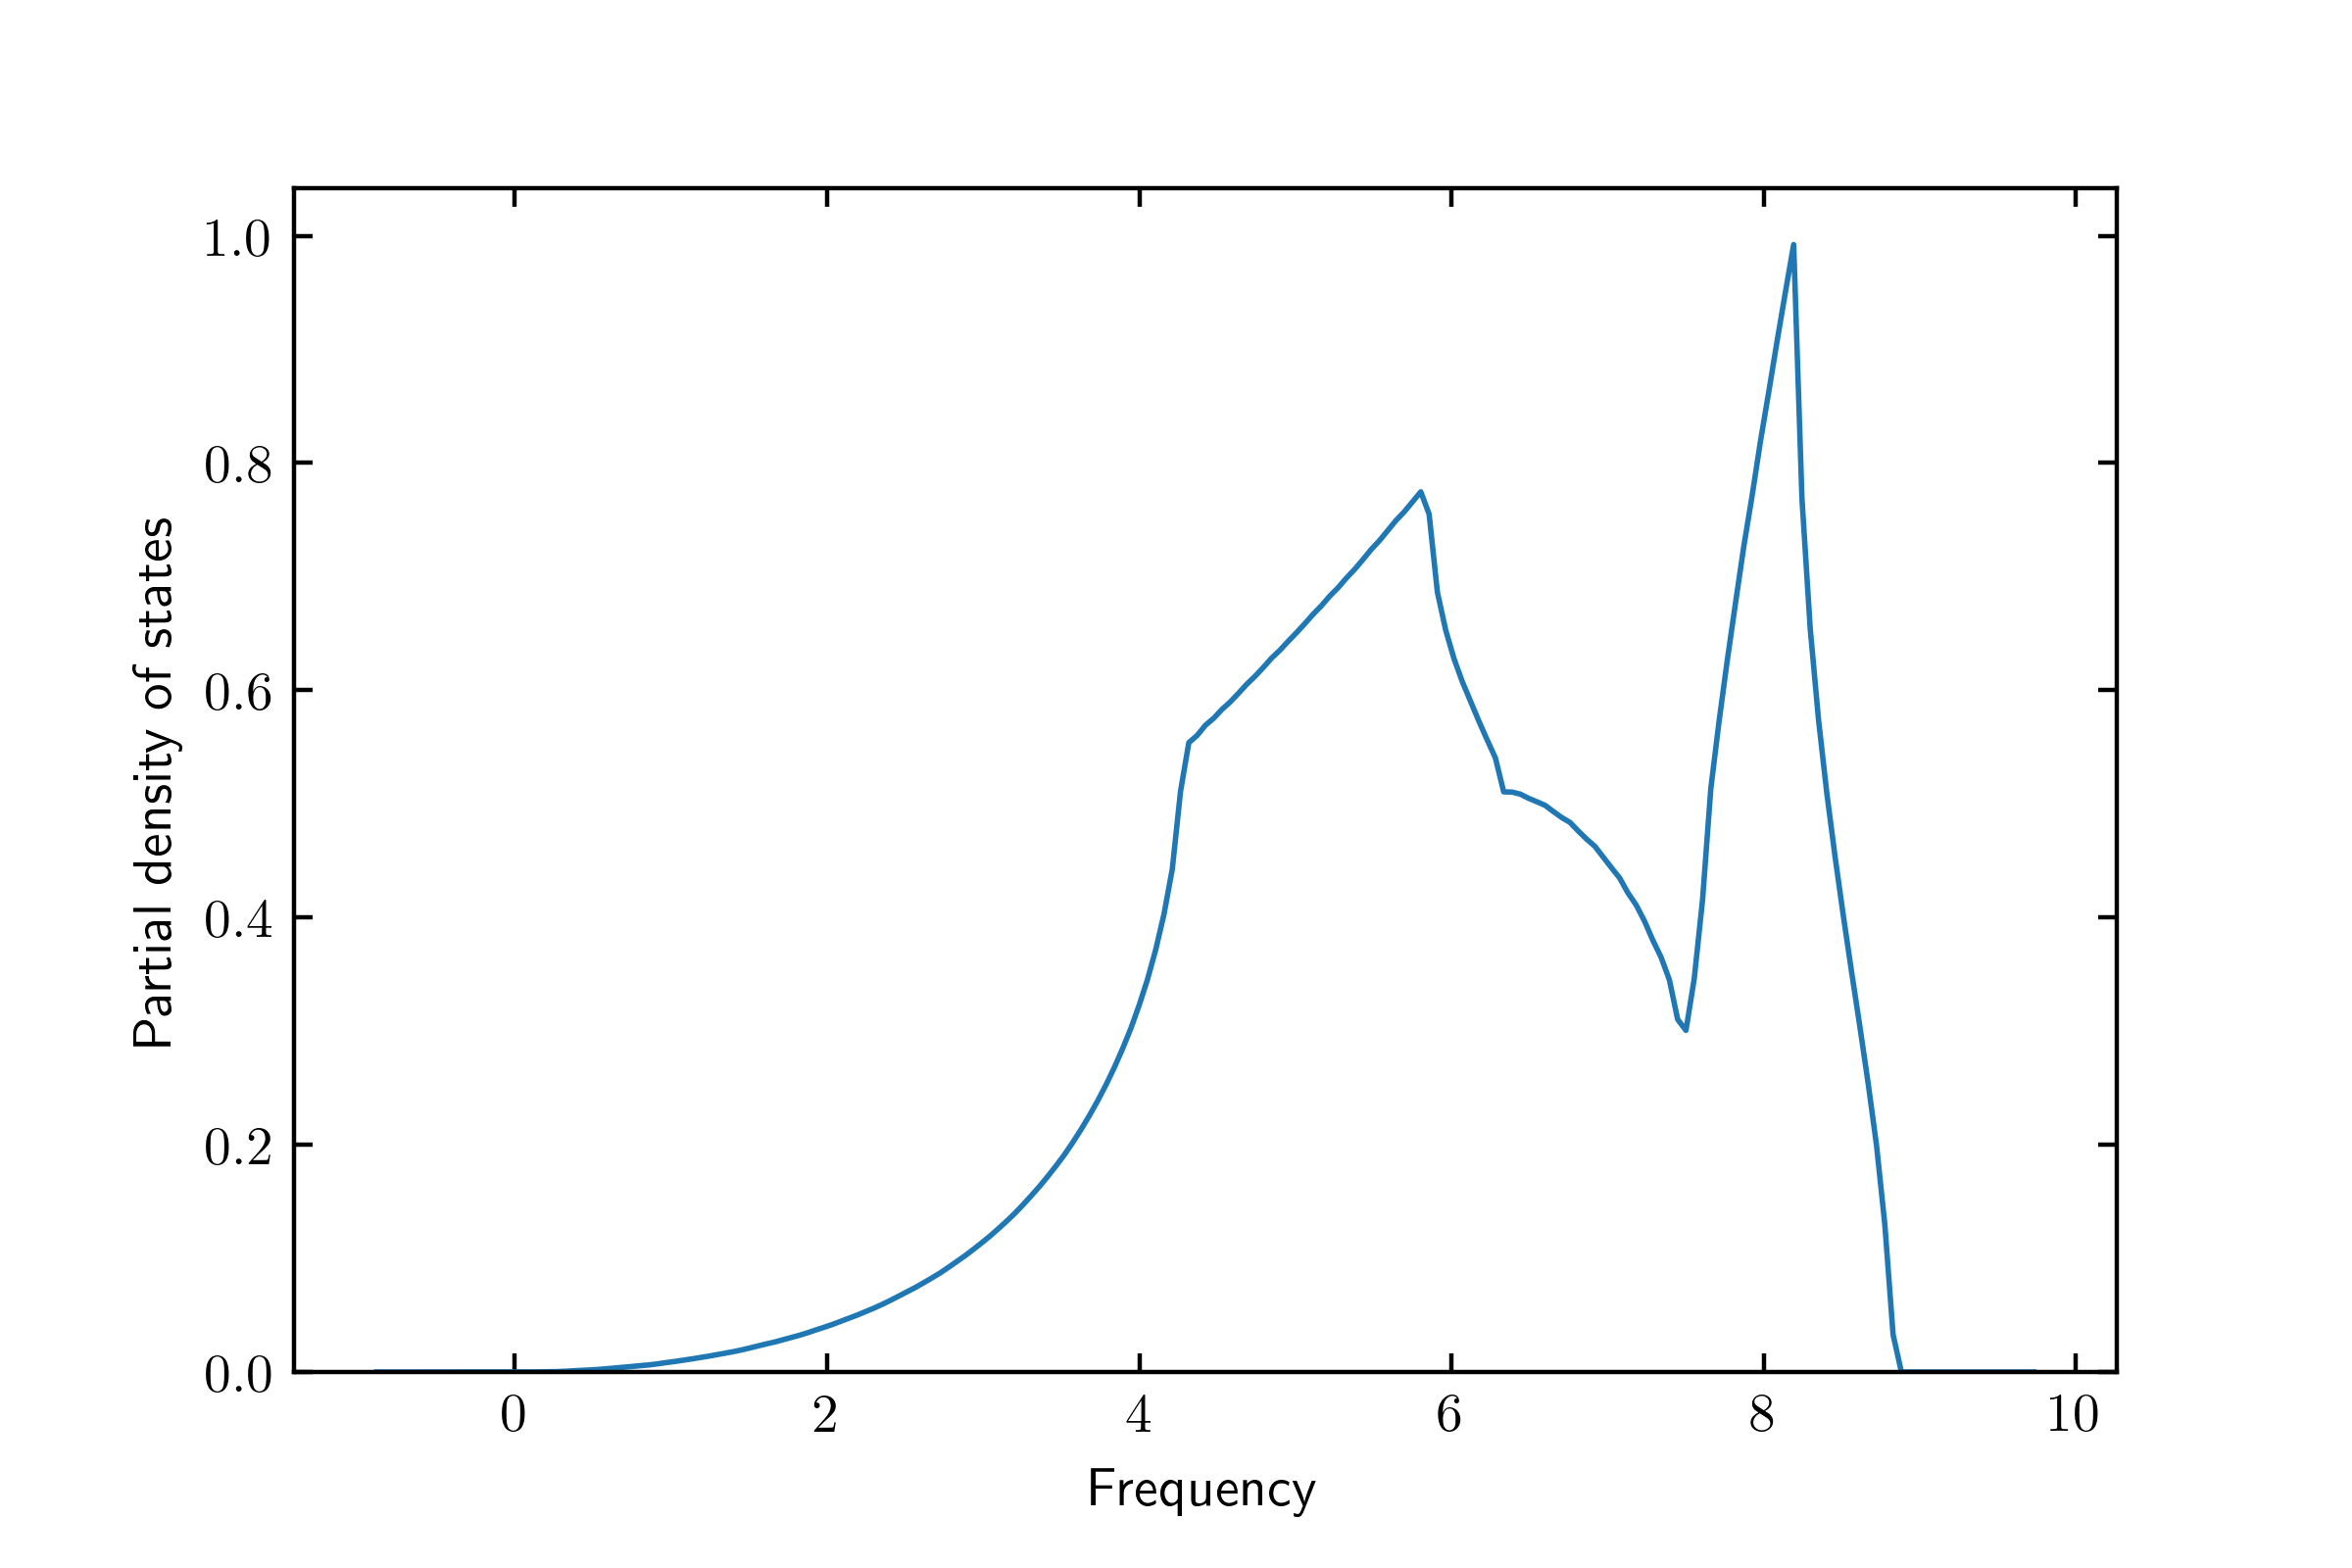

In [14]:
Image("projected_dos.png", width=600)

#### 5.4. Show thermal properties 

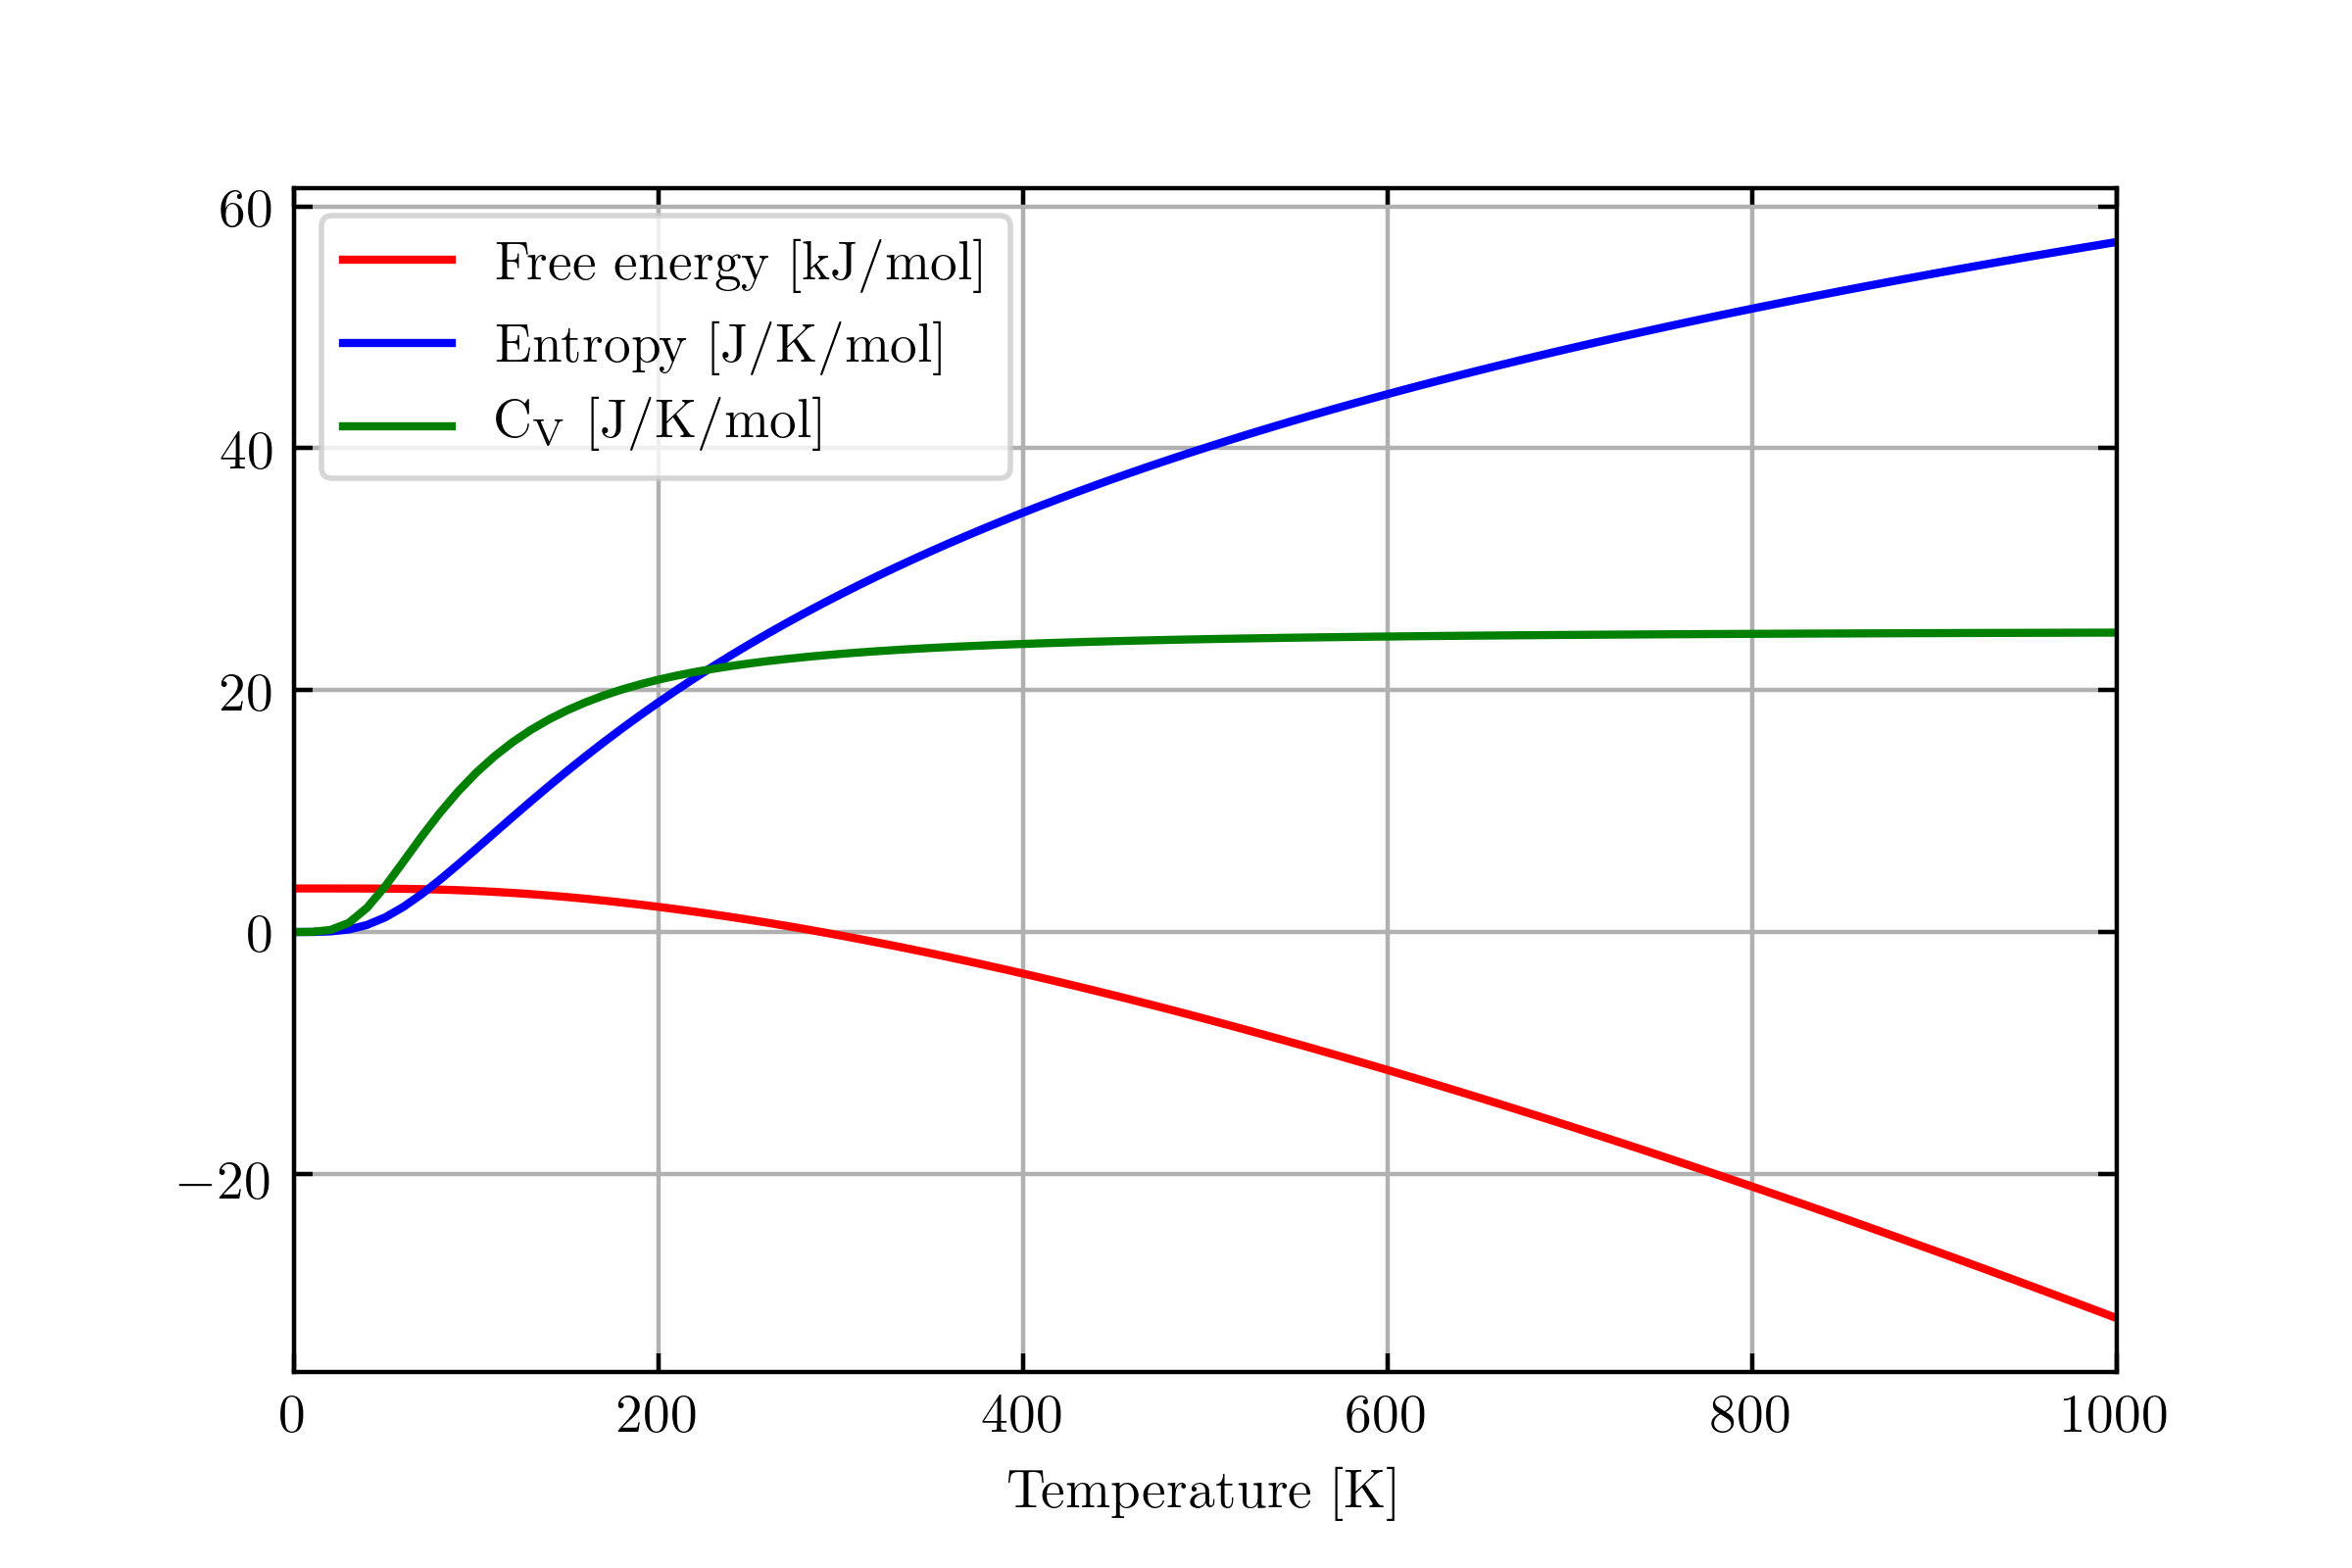

In [15]:
Image("thermal.png", width=600)